# Libraries

In [2]:
import itk
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntSlider #ToggleButtons, interact 
from itkwidgets import view
import numpy as np


# Preliminaries

In [3]:
def read_image(file_name):
    input_image = itk.imread(file_name)
    input_image = itk.array_from_image(input_image)
    input_image = (input_image/np.max(input_image))*255
    input_image = itk.image_from_array(input_image)
    return input_image

In [71]:

base = 'brats2018/Brats18_2013_10_1_'

flair_fn = base + 'flair.nii'
t1_fn = base + 't1.nii'
t1ce_fn = base + 't1ce.nii'
t2_fn = base + 't2.nii'
seg_fn = base + 'seg.nii'

flair = read_image(flair_fn)
t1 = read_image(t1_fn)
t1ce = read_image(t1ce_fn)
t2 = read_image(t2_fn)
seg = read_image(seg_fn)

print("Shape of Images : ",flair.shape, t1.shape, t1ce.shape, t2.shape, seg.shape)

Shape of Images :  (155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240)


In [72]:
type(flair)

itk.itkImagePython.itkImageD3

In [10]:
thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
print("Choose the slice using slice selection slider")
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices
# set true for continuous_update

# Define a function for plotting images
def plot_slices(slice):
    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR',fontsize = 30)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)


# Use the interactive() tool to create the visualization
interactive(plot_slices, slice=select_slice)  

Choose the slice using slice selection slider


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=154), Output()…

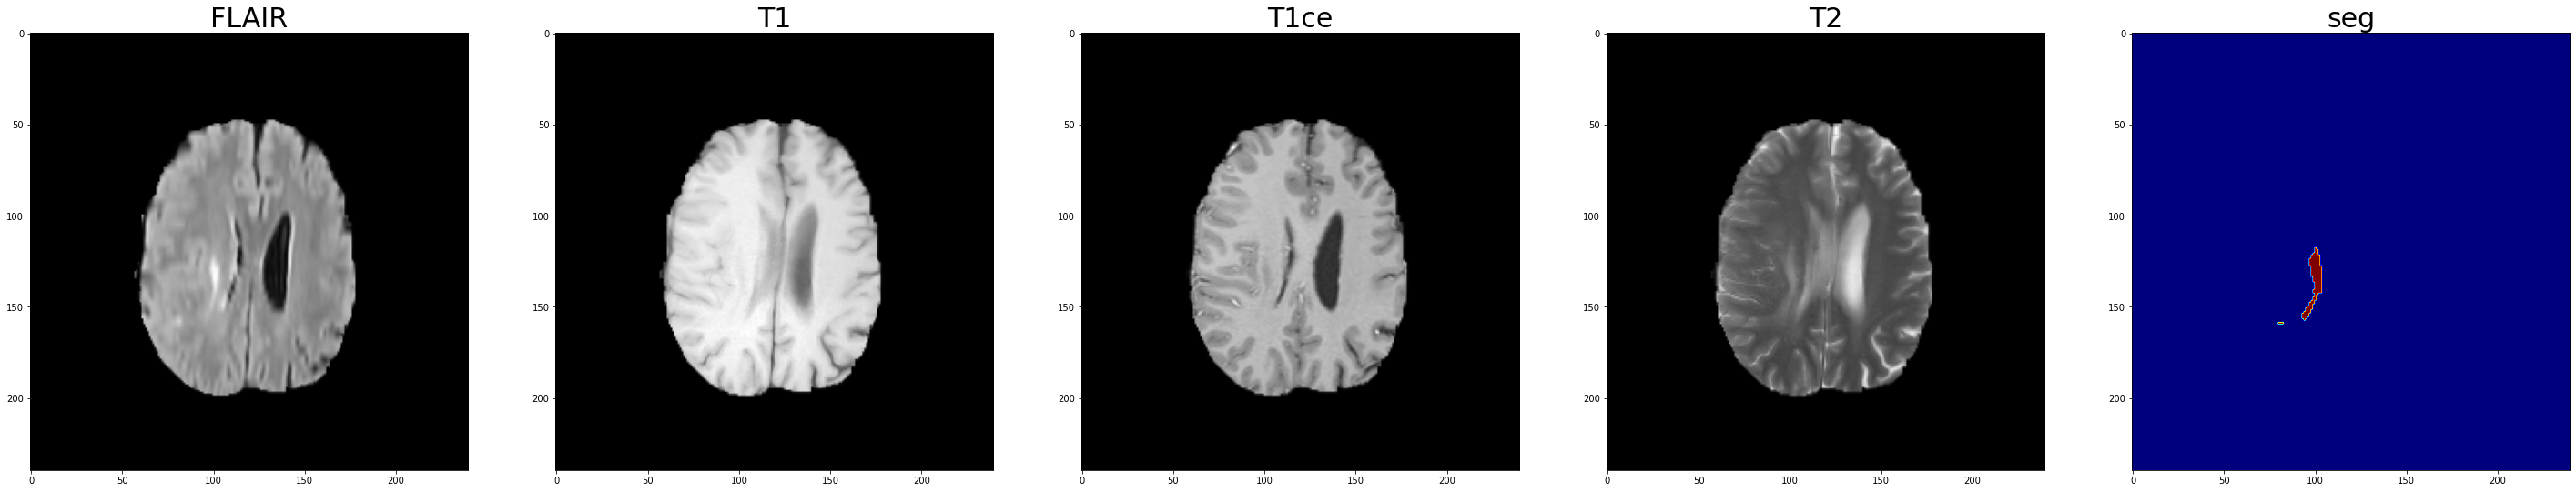

In [11]:
# individually analyse each slice

slice = 100

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR',fontsize = 30)
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg',fontsize = 30); # Jet cmap is used

In [13]:
image = flair #change image from here => [flair,t1,t1ce,t2,seg]

view(image, slicing_planes=True, gradient_opacity=0.8, ui_collapsed=False)

Viewer(geometries=[], gradient_opacity=0.8, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; prox…

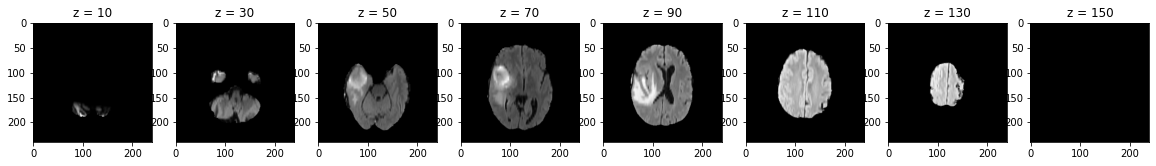

In [14]:
fig, ax = plt.subplots(1, 8, figsize=(20,160))
slices = [10, 30, 50, 70, 90, 110, 130, 150]
for i, z in enumerate(slices):
    ax[i].imshow(image[z],cmap='gray')
    ax[i].set_title('z = {}'.format(z))

# SEGMENTATION

## 1. Connected threshold 
The criterion used by the ConnectedThresholdImageFilter is based on an interval of intensity values provided by the user. Lower and upper threshold values should be provided. The regiongrowing algorithm includes those pixels whose intensities are inside the interval.
$$ I(x) \in [\mathrm{lower}, \mathrm{upper}] $$

In [17]:

flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

smoothen_flair = itk.CurvatureFlowImageFilter(flair,NumberOfIterations = 5, TimeStep = 0.125)
smoothen_t1 = itk.CurvatureFlowImageFilter(t1,NumberOfIterations = 5, TimeStep = 0.125)
smoothen_t1ce = itk.CurvatureFlowImageFilter(t1ce,NumberOfIterations = 5, TimeStep = 0.125)
smoothen_t2 = itk.CurvatureFlowImageFilter(t2,NumberOfIterations = 5, TimeStep = 0.125)


out_flair = itk.ConnectedThresholdImageFilter(smoothen_flair, Seed = (75,100,70), Lower = 100, Upper = 150, ReplaceValue = 255)
out_t1 = itk.ConnectedThresholdImageFilter(smoothen_t1, Seed = (75,125,70), Lower = 150, Upper = 200, ReplaceValue = 255)
out_t1ce = itk.ConnectedThresholdImageFilter(smoothen_t1ce, Seed = (75,100,70), Lower = 100, Upper = 150, ReplaceValue = 255)
out_t2 = itk.ConnectedThresholdImageFilter(smoothen_t2, Seed = (75,100,70), Lower = 100, Upper = 150, ReplaceValue = 255)

thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices
# set true for continuous_update

# Define a function for plotting images
def plot_slices(slice):

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(out_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(out_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(out_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(out_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    
interactive(plot_slices, slice=select_slice)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=154), Output()…

In [ ]:
slice = 100

fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
fig, ax = plt.subplots(1,5, figsize=(50,10));

ax[0].imshow(out_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30);
ax[1].imshow(out_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30);
ax[2].imshow(out_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30);
ax[3].imshow(out_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30);
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30);

# Otsu Segmentation

In [23]:
flair = flair.astype(itk.UC)
t1 = t1.astype(itk.UC)
t1ce = t1ce.astype(itk.UC)
t2 = t2.astype(itk.UC)

otsu_flair = itk.OtsuThresholdImageFilter(flair, OutsideValue = 0, InsideValue = 1)
otsu_t1 = itk.OtsuThresholdImageFilter(t1, OutsideValue = 0, InsideValue = 1)
otsu_t1ce = itk.OtsuThresholdImageFilter(t1ce, OutsideValue = 0, InsideValue = 1)
otsu_t2 = itk.OtsuThresholdImageFilter(t2, OutsideValue = 0, InsideValue = 1)

thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices

def plot_slices(slice):

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(otsu_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(otsu_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(otsu_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(otsu_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    
interactive(plot_slices, slice=select_slice)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=154), Output()…

# Neighborhood Connected

In [22]:
flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

filtered_flair = itk.CurvatureFlowImageFilter(flair, NumberOfIterations = 5, TimeStep = 0.125)
filtered_t1 = itk.CurvatureFlowImageFilter(t1, NumberOfIterations = 5, TimeStep = 0.125)
filtered_t1ce = itk.CurvatureFlowImageFilter(t1ce, NumberOfIterations = 5, TimeStep = 0.125)
filtered_t2 = itk.CurvatureFlowImageFilter(t2, NumberOfIterations = 5, TimeStep = 0.125)


neigh_flair = itk.NeighborhoodConnectedImageFilter(filtered_flair, Radius = 2, Lower =100, Upper =150, Seed = (75,100,70), ReplaceValue = 255)
neigh_t1 = itk.NeighborhoodConnectedImageFilter(filtered_t1, Radius = 2, Lower =100, Upper =150, Seed = (75,100,70), ReplaceValue = 255)
neigh_t1ce = itk.NeighborhoodConnectedImageFilter(filtered_t1ce, Radius = 2, Lower =100, Upper =150, Seed = (75,100,70), ReplaceValue = 255)
neigh_t2 = itk.NeighborhoodConnectedImageFilter(filtered_t2, Radius = 2, Lower =100, Upper =150, Seed = (75,100,70), ReplaceValue = 255)


thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices

def plot_slices(slice):

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(neigh_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(neigh_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(neigh_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(neigh_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    
interactive(plot_slices, slice=select_slice)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=154), Output()…

# Confidence Connected

In [26]:
flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

filt_flair = itk.CurvatureFlowImageFilter(flair, NumberOfIterations = 5, TimeStep = 0.125)
filt_t1 = itk.CurvatureFlowImageFilter(t1, NumberOfIterations = 5, TimeStep = 0.125)
filt_t1ce = itk.CurvatureFlowImageFilter(t1ce, NumberOfIterations = 5, TimeStep = 0.125)
filt_t2 = itk.CurvatureFlowImageFilter(t2, NumberOfIterations = 5, TimeStep = 0.125)


conf_flair = itk.ConfidenceConnectedImageFilter(filt_flair, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = (75,100,70), ReplaceValue = 255)
conf_t1 = itk.ConfidenceConnectedImageFilter(filt_t1, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = (75,100,70), ReplaceValue = 255)
conf_t1ce = itk.ConfidenceConnectedImageFilter(filt_t1ce, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = (75,100,70), ReplaceValue = 255)
conf_t2 = itk.ConfidenceConnectedImageFilter(filt_t2, Multiplier = 2.5, NumberOfIterations = 5, InitialNeighborhoodRadius = 1, Seed = (75,100,70), ReplaceValue = 255)


thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices

def plot_slices(slice):

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(conf_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(conf_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(conf_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(conf_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    
interactive(plot_slices, slice=select_slice)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=154), Output()…

# Isolated Connected

In [33]:
flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

iso_flair = itk.IsolatedConnectedImageFilter(flair, Lower = 100, Seed1 = 75, Seed2 = 100)
iso_t1 = itk.IsolatedConnectedImageFilter(t1, Lower = 100, Seed1 = 75, Seed2 = 100)
iso_t1ce = itk.IsolatedConnectedImageFilter(t1ce, Lower = 100, Seed1 = 75, Seed2 = 100)
iso_t2 = itk.IsolatedConnectedImageFilter(t2, Lower = 100, Seed1 = 75, Seed2 = 100)

thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices

def plot_slices(slice):

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(iso_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(iso_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(iso_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(iso_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    
interactive(plot_slices, slice=select_slice)


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=154), Output()…

# Canny-Edge Level Set Segmentation

In [66]:
flair = flair.astype(itk.F)
t1 = t1.astype(itk.F)
t1ce = t1ce.astype(itk.F)
t2 = t2.astype(itk.F)

Ani_flair = itk.GradientAnisotropicDiffusionImageFilter(flair, NumberOfIterations = 5, TimeStep = 0.125, ConductanceParameter = 1)
Ani_t1 = itk.GradientAnisotropicDiffusionImageFilter(t1, NumberOfIterations = 5, TimeStep = 0.125, ConductanceParameter = 1)
Ani_t1ce = itk.GradientAnisotropicDiffusionImageFilter(t1ce, NumberOfIterations = 5, TimeStep = 0.125, ConductanceParameter = 1)
Ani_t2 = itk.GradientAnisotropicDiffusionImageFilter(t2, NumberOfIterations = 5, TimeStep = 0.125, ConductanceParameter = 1)
# FeatureImage = flair_ani

canny_flair = itk.CannySegmentationLevelSetImageFilter(flair, FeatureImage = Ani_flair, AdvectionScaling = 10, CurvatureScaling = 0, PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15, MaximumRMSError = 0.01, IsoSurfaceValue = 2)
canny_t1 = itk.CannySegmentationLevelSetImageFilter(t1, FeatureImage = Ani_t1, AdvectionScaling = 10, CurvatureScaling = 0, PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15, MaximumRMSError = 0.01, IsoSurfaceValue = 2)
canny_t1ce = itk.CannySegmentationLevelSetImageFilter(t1ce, FeatureImage = Ani_t1ce, AdvectionScaling = 10, CurvatureScaling = 0, PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15, MaximumRMSError = 0.01, IsoSurfaceValue = 2)
canny_t2 = itk.CannySegmentationLevelSetImageFilter(t2, FeatureImage = Ani_t2, AdvectionScaling = 10, CurvatureScaling = 0, PropagationScaling = 0, Variance =0.1, Threshold = 7, NumberOfIterations = 15, MaximumRMSError = 0.01, IsoSurfaceValue = 2)

thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices

def plot_slices(slice):

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(canny_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(canny_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(canny_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(canny_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    
interactive(plot_slices, slice=select_slice)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=154), Output()…

# Fast Marching

In [38]:
def fastMarch(image,seed,sigma, alpha, beta, time_threshold):
    # segments = {'left ventricle': [81, 114, 1.0, -0.5, 3.0, 100], 'right ventricle': [99, 114, 1.0, -0.5, 3.0, 100], 'white matter': [56, 92, 1.0, -0.3, 2.0, 200], 'gray mater': [40, 90, 0.5, -0.3, 2.0, 100]}
    
    InternalPixelType = itk.F
    image = flair.astype(InternalPixelType)
    Dimension = 3
    InternalImageType = itk.Image[InternalPixelType, Dimension]
    OutputPixelType = itk.UC
    OutputImageType = itk.Image[OutputPixelType, Dimension]
    thresholder = itk.BinaryThresholdImageFilter[InternalImageType, OutputImageType].New()

    
    thresholder.SetLowerThreshold(0.0)
    thresholder.SetUpperThreshold(time_threshold)

    thresholder.SetOutsideValue(0)
    thresholder.SetInsideValue(255)

    caster1 = itk.RescaleIntensityImageFilter[InternalImageType, OutputImageType].New()
    smoothing = itk.CurvatureAnisotropicDiffusionImageFilter[InternalImageType, InternalImageType].New()
    gradientMagnitude = itk.GradientMagnitudeRecursiveGaussianImageFilter[InternalImageType, InternalImageType].New()
    sigmoid = itk.SigmoidImageFilter[InternalImageType, InternalImageType].New()

    sigmoid.SetOutputMinimum(0.0)
    sigmoid.SetOutputMaximum(1.0)

    fastMarching = itk.FastMarchingImageFilter[InternalImageType, InternalImageType].New()


    smoothing.SetInput(image)
    gradientMagnitude.SetInput(smoothing.GetOutput())
    sigmoid.SetInput(gradientMagnitude.GetOutput())
    fastMarching.SetInput(sigmoid.GetOutput())
    thresholder.SetInput(fastMarching.GetOutput())

    smoothing.SetTimeStep(0.125)
    smoothing.SetNumberOfIterations(5)
    smoothing.SetConductanceParameter(9.0)
    
    gradientMagnitude.SetSigma(sigma)

    sigmoid.SetAlpha(alpha)
    sigmoid.SetBeta(beta)

    seed_position = [(seed[0], seed[1], seed[2])]
    seed_value = 0

    NodeType = itk.LevelSetNode[InternalPixelType, Dimension]
    seed_container = itk.VectorContainer[itk.UI, NodeType].New()
    seed_container.Initialize()

    for i,p in enumerate(seed_position):
        node = NodeType()
        node.SetIndex( p )
        node.SetValue( 0.0 )
        seed_container.InsertElement( i, node )
    fastMarching.SetTrialPoints(seed_container)


    fastMarching.SetOutputSize(reader.GetOutput().GetBufferedRegion().GetSize())
    stoppingTime = 500
    fastMarching.SetStoppingValue(stoppingTime)

    slice = 79
    fig, ax = plt.subplots(1, 5, figsize=(20,10))
    ax[0].imshow(image[slice], cmap='gray', vmin=0, vmax=255)
    ax[0].set_title('Input')
    ax[0].scatter(seed[1], seed[2], color='r')
    ax[1].imshow(gradientMagnitude.GetOutput()[slice], cmap='gray')
    ax[1].set_title('Gradient Magnitude')
    ax[2].imshow(sigmoid.GetOutput()[slice], cmap='gray')
    ax[2].set_title('Sigmoid')
    ax[3].imshow(fastMarching.GetOutput()[slice], cmap='gray')
    ax[3].set_title('Fast march')
    ax[4].imshow(thresholder.GetOutput()[slice], cmap='gray')
    ax[4].set_title('Thresholded')

    return gradientMagnitude.GetOutput(),sigmoid.GetOutput(),fastMarching.GetOutput(),thresholder.GetOutput()

In [32]:
seed = [0,0,0]
seed[0], seed[1], seed[2], sigma, alpha, beta, time_threshold = [79, 80, 110, 1.0, -0.5, 3.0, 250]

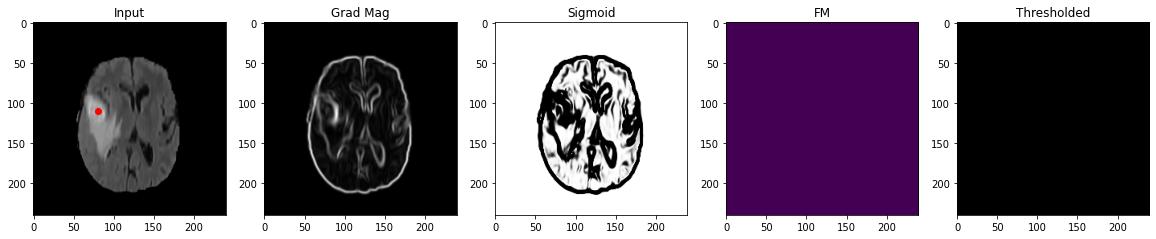

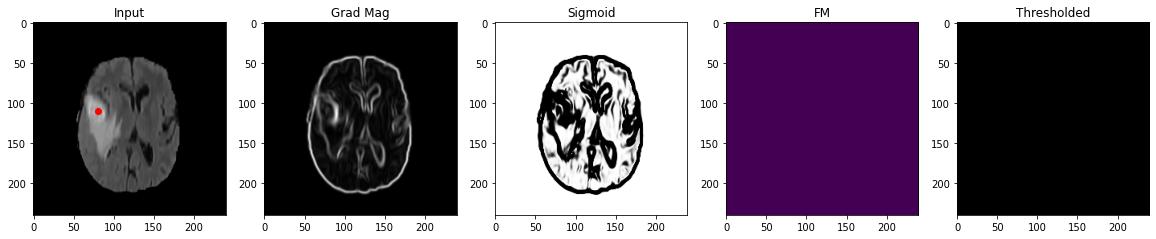

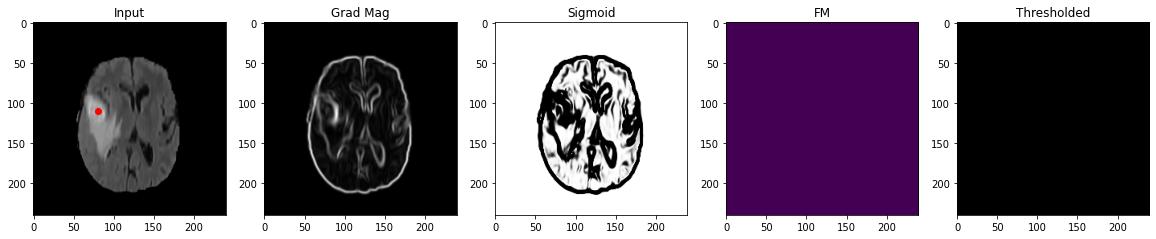

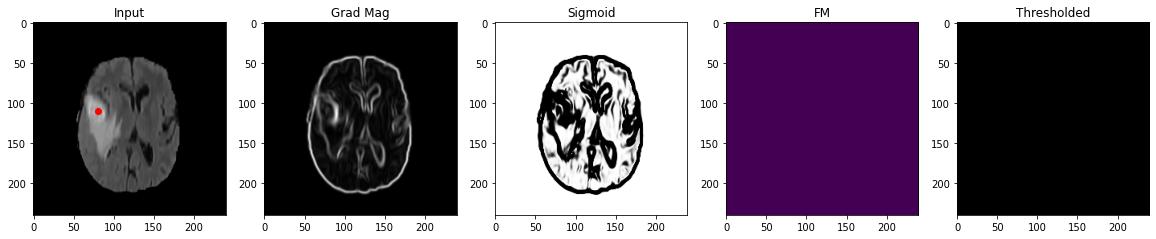

In [39]:
gradmag_flair, sigmoid_flair, fastmarch_flair, binary_flair =  fastMarch(flair, seed, sigma, alpha, beta, time_threshold)
gradmag_t1, sigmoid_t1, fastmarch_t1, binary_t1 =  fastMarch(t1, seed, sigma, alpha, beta, time_threshold)
gradmag_t1ce, sigmoid_t1ce, fastmarch_t1ce, binary_t1ce =  fastMarch(t1ce, seed, sigma, alpha, beta, time_threshold)
gradmag_t2, sigmoid_t2, fastmarch_t2, binary_t2 =  fastMarch(t2, seed, sigma, alpha, beta, time_threshold)

# WaterShed

In [81]:
def watershed(filename,threshold,level):

    Dimension = 3
    image = read_image(filename)

    FloatPixelType = itk.ctype("float")
    FloatImageType = itk.Image[FloatPixelType, Dimension]

    # reader = itk.ImageFileReader[FloatImageType].New()
    # reader.SetFileName(image)


    diffusionFilter = itk.GradientAnisotropicDiffusionImageFilter[FloatImageType, FloatImageType].New()
    diffusionFilter.SetNumberOfIterations(5)
    diffusionFilter.SetTimeStep(0.125)
    diffusionFilter.SetConductanceParameter(1.0)

    diffusionFilter.SetInput(image)#reader.GetOutput())

    gradientMagnitude = itk.GradientMagnitudeImageFilter.New(Input=diffusionFilter.GetOutput())
    watershed = itk.WatershedImageFilter.New(Input=gradientMagnitude.GetOutput())


    watershed.GetOutput()

    watershed.SetThreshold(threshold)
    watershed.SetLevel(level)

    LabeledImageType = type(watershed.GetOutput())

    PixelType = itk.ctype("unsigned char")
    RGBPixelType = itk.RGBPixel[PixelType]
    RGBImageType = itk.Image[RGBPixelType, Dimension]

    ScalarToRGBColormapFilterType = itk.ScalarToRGBColormapImageFilter[LabeledImageType, RGBImageType]
    colormapImageFilter = ScalarToRGBColormapFilterType.New()
    colormapImageFilter.SetColormap(itk.ScalarToRGBColormapImageFilterEnums.RGBColormapFilter_Jet)
    colormapImageFilter.SetInput(watershed.GetOutput())  
    out = colormapImageFilter.GetOutput()#[100]  
    #plt.imshow(colormapImageFilter.GetOutput()[100])
    return out


In [82]:
watershed_flair = watershed(flair_fn,0.2,0.9)
watershed_t1 = watershed(t1_fn,0.2,0.9)
watershed_t1ce = watershed(t1ce_fn,0.2,0.9)
watershed_t2 = watershed(t2_fn,0.2,0.9)


thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices

def plot_slices(slice):

    # fig, ax = plt.subplots(1,5, figsize=(50,10))
    # ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    # ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    # ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    # ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    # ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(watershed_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
    ax[1].imshow(watershed_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
    ax[2].imshow(watershed_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
    ax[3].imshow(watershed_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    
interactive(plot_slices, slice=select_slice)

TypeError: Expecting argument of type itkImageF3 or itkImageSourceIF3.
Additional information:
Wrong number or type of arguments for overloaded function 'itkImageToImageFilterIF3IF3_SetInput'.
  Possible C/C++ prototypes are:
    itkImageToImageFilterIF3IF3::SetInput(itkImageF3 const *)
    itkImageToImageFilterIF3IF3::SetInput(unsigned int,itkImageF3 const *)


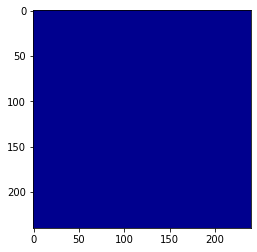

In [25]:
# import itk
# import cv2 as cv
# import matplotlib.pyplot as plt

# Dimension = 3

# FloatPixelType = itk.ctype("float")
# FloatImageType = itk.Image[FloatPixelType, Dimension]

# reader = itk.ImageFileReader[FloatImageType].New()
# reader.SetFileName(flair_fn)


# diffusionFilter = itk.GradientAnisotropicDiffusionImageFilter[FloatImageType, FloatImageType].New()
# diffusionFilter.SetNumberOfIterations(5)
# diffusionFilter.SetTimeStep(0.125)
# diffusionFilter.SetConductanceParameter(1.0)

# diffusionFilter.SetInput(reader.GetOutput())

# gradientMagnitude = itk.GradientMagnitudeImageFilter.New(Input=diffusionFilter.GetOutput())
# watershed = itk.WatershedImageFilter.New(Input=gradientMagnitude.GetOutput())

# watershed.SetThreshold(10)
# watershed.SetLevel(2)
# watershed.GetOutput()

# threshold = 0.2
# level = 0.9
# watershed.SetThreshold(threshold)
# watershed.SetLevel(level)

# LabeledImageType = type(watershed.GetOutput())

# PixelType = itk.ctype("unsigned char")
# RGBPixelType = itk.RGBPixel[PixelType]
# RGBImageType = itk.Image[RGBPixelType, Dimension]

# ScalarToRGBColormapFilterType = itk.ScalarToRGBColormapImageFilter[LabeledImageType, RGBImageType]
# colormapImageFilter = ScalarToRGBColormapFilterType.New()
# colormapImageFilter.SetColormap(itk.ScalarToRGBColormapImageFilterEnums.RGBColormapFilter_Jet)
# colormapImageFilter.SetInput(watershed.GetOutput())    
# plt.imshow(colormapImageFilter.GetOutput()[100])


In [ ]:
# flair = flair.astype(itk.F)
# t1 = t1.astype(itk.F)
# t1ce = t1ce.astype(itk.F)
# t2 = t2.astype(itk.F)


# diffuse_flair = flair #itk.GradientAnisotropicDiffusionImageFilter(flair,NumberOfIterations=5, TimeStep = 0.125, ConductanceParameter = 1)
# gradientMagnitude_flair = itk.GradientMagnitudeImageFilter(diffuse_flair)
# watershed_flair = itk.WatershedImageFilter(flair,threshold = 0.001, level = 0.15)

# diffuse_t1 = t1 #itk.GradientAnisotropicDiffusionImageFilter(t1,NumberOfIterations=5, TimeStep = 0.125, ConductanceParameter = 1)
# gradientMagnitude_t1 = itk.GradientMagnitudeImageFilter(diffuse_t1)
# watershed_t1 = itk.WatershedImageFilter(t1,threshold = 0.001, level = 0.15)

# diffuse_t1ce = t1ce #itk.GradientAnisotropicDiffusionImageFilter(t1ce,NumberOfIterations=5, TimeStep = 0.125, ConductanceParameter = 1)
# gradientMagnitude_t1ce = itk.GradientMagnitudeImageFilter(diffuse_t1ce)
# watershed_t1ce = itk.WatershedImageFilter(t1ce,threshold = 0.001, level = 0.15)

# diffuse_t2 = t2 #itk.GradientAnisotropicDiffusionImageFilter(t2,NumberOfIterations=5, TimeStep = 0.125, ConductanceParameter = 1)
# gradientMagnitude_t2 = itk.GradientMagnitudeImageFilter(diffuse_t2)
# watershed_t2 = itk.WatershedImageFilter(t2,threshold = 0.001, level = 0.15)


# print(watershed_flair.shape)
# watershed_flair = itk.GetArrayFromImage(watershed_flair[100])
# plt.imshow(watershed_flair)
# thresh = min(flair.shape[0],t1.shape[0],t1ce.shape[0],t2.shape[0],seg.shape[0]) # find maximum number of slices, slice number [0,155]
# select_slice = IntSlider(min=0, max=thresh-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices

# def plot_slices(slice):

#     # fig, ax = plt.subplots(1,5, figsize=(50,10))
#     # ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
#     # ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
#     # ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
#     # ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
#     # ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)

#     fig, ax = plt.subplots(1,5, figsize=(50,10))
#     ax[0].imshow(watershed_flair[slice], cmap='gray'), ax[0].set_title('Flair',fontsize = 30)
#     ax[1].imshow(watershed_t1[slice], cmap='gray'), ax[1].set_title('T1',fontsize = 30)
#     ax[2].imshow(watershed_t1ce[slice], cmap='gray'), ax[2].set_title('T1ce',fontsize = 30)
#     ax[3].imshow(watershed_t2[slice], cmap='gray'), ax[3].set_title('T2',fontsize = 30)
#     ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('Seg',fontsize = 30)
    
# interactive(plot_slices, slice=select_slice)